## Import libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from gurobipy import *
from collections import defaultdict
import csv
from datetime import datetime
import os

## Read and preprocess data


In [2]:
def load_data(file_path):
    data_dict = dict()

    with open(file_path) as file:
        reader = csv.DictReader(file)
        for row in reader:
            if row['Numéro du groupe'] != '':
                heures, minutes, _ = map(int, row['TransitTime'].split(':')) 
                total_minutes = heures * 60 + minutes
                data_dict[int(float(row['Numéro du groupe']))] = (
                    int(float(row['Femmes'])),
                    int(float(row['Hommes'])),
                    int(float(row['WCHR'])),
                    total_minutes
                )

    return data_dict

# Load data for each file

file_names = ["DataSeating 2024.csv","22Oct.csv","23Oct.csv","24Oct.csv","30Oct.csv", "5Nov.csv", "7Nov.csv"]
data_directory = 'data'
# for eachy dictionary : dict[Numéro du groupe : (Femmes, Hommes, WCHR, TransitTime)]
Oct21, Oct22,Oct23, Oct24, Oct30, Nov5, Nov7= [load_data(os.path.join(data_directory, file)) for file in file_names]

Transforming data to access each passenger's Id


In [3]:
def create_passengers_dict(data):
    passengers_dict = {}
    j = 1

    for group_num, group_data in data.items():
        weights = {'Femmes': 70, 'Hommes': 85, 'WCHR': 10000}  # Weight per passenger

        # Extracting data
        femmes, hommes, wchr, total_minutes = group_data

        # Enumerating passengers
        for _ in range(femmes + hommes + wchr):
            if femmes > 0:
                weight = weights['Femmes']
                passengers_dict[j] = {'gender': 'Femmes', 'group': group_num, 'weight': weight,
                                      'connection_time': total_minutes}
                femmes -= 1
            elif hommes > 0:
                weight = weights['Hommes']
                passengers_dict[j] = {'gender': 'Hommes', 'group': group_num, 'weight': weight,
                                      'connection_time': total_minutes}
                hommes -= 1
            else:
                weight = weights['WCHR']
                passengers_dict[j] = {'gender': 'WCHR', 'group': group_num, 'weight': weight,
                                      'connection_time': total_minutes}
                wchr -= 1
            j += 1

    return passengers_dict

Passengers_Oct21 = create_passengers_dict(Oct21)
Passengers_Oct22 = create_passengers_dict(Oct22)
Passengers_Oct23 = create_passengers_dict(Oct23)
Passengers_Oct24 = create_passengers_dict(Oct24)
Passengers_Oct30 = create_passengers_dict(Oct30)
Passengers_Nov5 = create_passengers_dict(Nov5)
Passengers_Nov7 = create_passengers_dict(Nov7)

# Example usage for Nov5
print(Passengers_Nov5)

{1: {'gender': 'Femmes', 'group': 1, 'weight': 70, 'connection_time': 0}, 2: {'gender': 'Hommes', 'group': 1, 'weight': 85, 'connection_time': 0}, 3: {'gender': 'Hommes', 'group': 1, 'weight': 85, 'connection_time': 0}, 4: {'gender': 'Hommes', 'group': 2, 'weight': 85, 'connection_time': 60}, 5: {'gender': 'Femmes', 'group': 3, 'weight': 70, 'connection_time': 165}, 6: {'gender': 'Hommes', 'group': 3, 'weight': 85, 'connection_time': 165}, 7: {'gender': 'Femmes', 'group': 4, 'weight': 70, 'connection_time': 0}, 8: {'gender': 'Hommes', 'group': 4, 'weight': 85, 'connection_time': 0}, 9: {'gender': 'WCHR', 'group': 4, 'weight': 10000, 'connection_time': 0}, 10: {'gender': 'Femmes', 'group': 5, 'weight': 70, 'connection_time': 0}, 11: {'gender': 'Femmes', 'group': 5, 'weight': 70, 'connection_time': 0}, 12: {'gender': 'Femmes', 'group': 5, 'weight': 70, 'connection_time': 0}, 13: {'gender': 'Femmes', 'group': 6, 'weight': 70, 'connection_time': 0}, 14: {'gender': 'Hommes', 'group': 6, 'we

# Static model

In [4]:
# Function to create optimization model and variables

ranks = 29  # number of rows in the aircraft
ns = 7 * ranks  # number of seats

def create_model_and_variables(passengers_dict):
    n = len(passengers_dict)  # number of passengers

    m = Model('statique')  # Model initialization

    # Adding variables
    S = {(i, j): m.addVar(vtype=GRB.BINARY, name=f'j{i}') for i in range(1, n + 1) for j in range(1, ns + 1)}

    # Adding constraints
    # Max. 1 seat per passenger
    for j in range(1, ns + 1):
        m.addConstr(quicksum(S[(i, j)] for i in range(1, n + 1)) <= 1, name="PassengerMax")

    # Each passenger has one and only one seat
    for i in range(1, n + 1):
        m.addConstr(quicksum(S[(i, j)] for j in range(1, ns + 1)) == 1, name="SeatMax")

    # The central aisle is left free
    for i in range(1, n + 1):
        for j in range(1, ns + 1):
            if j % 7 == 4:
                m.addConstr(S[(i, j)] == 0)

    # Baricenter
    x_g = LinExpr()
    y_g = LinExpr()

    total_weight = quicksum(passengers_dict[i]['weight'] for i in range(1, n + 1)).getValue()

    for i in range(1, n + 1):
        j_k = 1

        for j in range(1, ns + 1):
            weight_ij = passengers_dict[i]['weight'] / total_weight

            if j % 7 == 0:
                x_g += (7 * S[i, j] * weight_ij)
                y_g += (j_k * S[i, j] * weight_ij)
                j_k += 1
            else:
                x_g += ((j % 7) * S[i, j] * weight_ij)
                y_g += (((j // 7) + 1) * S[i, j] * weight_ij)

    m.addConstr(x_g >= 3)
    m.addConstr(x_g <= 5)
    m.addConstr(y_g >= 13)
    m.addConstr(y_g <= 17)

    # Disabled passengers occupy 4 spaces on the central aisle
    for passenger in passengers_dict:
        if passengers_dict[passenger]['gender']=='WCHR':
            #Seats are shortened by row (from 7 to 7)
            for j in range(1, ns+1-8, 7):             
            
                x1, x2, x3, x4, x5, x6, x7 = j,j+1,j+2,j+3,j+4,j+5,j+6
                
                #A seat is fixed in rows 3 or 5.
                m.addConstr(S[(passenger, x1)] + S[(passenger, x2)] +  S[(passenger, x6)] + S[(passenger, x7)] ==0 )   
                
                #The seat overlooking the alley is closed off
                m.addConstr(S[(passenger, x3)]+sum(S[(i, x3-1)] for i in passengers_dict) <= 1) 
                #We close the 2 seats behind
                m.addConstr(S[(passenger, x3)]+sum(S[(i, x3+7)] for i in passengers_dict) <= 1) 
                m.addConstr(S[(passenger, x3)]+sum(S[(i, x3+6)] for i in passengers_dict) <= 1)
                #The seat overlooking the alley is closed off
                m.addConstr(S[(passenger, x5)]+sum(S[(i, x5+1)] for i in passengers_dict) <= 1) 
                #We close the 2 seats behind
                m.addConstr(S[(passenger, x5)]+sum(S[(i, x5+7)] for i in passengers_dict) <= 1) 
                m.addConstr(S[(passenger, x5)]+sum(S[(i, x5+8)] for i in passengers_dict) <= 1)
            #Disabled passengers cannot be in the last row   
            m.addConstr(sum(S[(passenger, k)] for k in range (ns-6, ns+1)) == 0)  

    return m, S

In [38]:
#Choice of the dictionnary

Passengers=Passengers_Oct24

In [39]:
# Create models and variables for each date
n=len(Passengers)
m, S = create_model_and_variables(Passengers)


Objective functions

In [40]:
# Transit passengers are seated at the front of the aircraft
def obj_transit(S, passengers_dict):
    T = {}

    for passenger in passengers_dict:
        if passengers_dict[passenger]['connection_time'] > 0:  # transit passenger
            T[passenger] = passengers_dict[passenger]['connection_time']

    P = list(T.keys())  # returns a list of transit passenger identifiers

    f = 0
    for k in range(len(P)):
        for j in range(1, ns + 1):
            q = (j - 1) // 7
            f += S[(P[k], j)] * (1 / T[P[k]]) * q

    return f


In [41]:
def seat_coordinates(seats):
    coordinates = []
    for j in range(len(seats)):
        if (seats[j] % 7 == 0):
            x = 7
            y = (seats[j] // 7) 
        else:
            x = seats[j] % 7
            y = (seats[j] // 7) +1 
        coordinates.append((x, y))
    return coordinates

In [42]:
alpha=0.3

def obj_dist(Passengers, alpha):

    obj = LinExpr()
    X={}
    Y={}
    coord = seat_coordinates([j for j in range(1, ns+1)])
    for i in range(1, n + 1):
        X[i]=m.addVar(vtype=GRB.INTEGER)
        Y[i]=m.addVar(vtype=GRB.INTEGER)

        for k in range(i + 1, n + 1):  
            if  i!=k and Passengers[i]['group'] == Passengers[k]['group']:  #Si passager i et passager k sont dans le même groupe

                xi, yi = 0, 0
                xk, yk = 0, 0

                for j in range (len(coord)):                                      #On parcourt les sièges
                    xi, yi = xi + S[(i,j+1)]*coord[j][0], yi + S[(i,j+1)]*coord[j][1]
                    xk, yk =  xk + S[(k,j+1)]*coord[j][0], yk + S[(k,j+1)]*coord[j][1]
                
                m.addConstr(X[i]>=xi - xk)
                m.addConstr(X[i]>= -xi + xk)
                m.addConstr(Y[i]>=yi - yk)
                m.addConstr(Y[i]>= -yi + yk)
                dist_x = X[i] 
                dist_y = Y[i]
                obj += alpha*dist_x + (1-alpha)*dist_y  
                
    return obj



In [43]:

m.setObjective(obj_transit(S, Passengers) + obj_dist(Passengers, alpha) , GRB.MINIMIZE)

In [44]:
# Choice of minimalist display settings
m.params.outputflag = 0 # mute mode
m.update() # Model update
display(m) # Text mode display of PL



<gurobi.Model MIP instance statique: 6163 constrs, 33620 vars, Parameter changes: Username=(user-defined), OutputFlag=0>

In [45]:
#Resolution
m.Params.timeLimit = 120.0
m.optimize()
# Solution display 
print()
print("Seats on the plane for Oct21 are as follows:", [(i, j) for i in range(1, len(Passengers) + 1) for j in range(1, ns + 1) if S[(i, j)].x])




Seats on the plane for Oct21 are as follows: [(1, 13), (2, 27), (3, 20), (4, 19), (5, 21), (6, 15), (7, 22), (8, 8), (9, 10), (10, 170), (11, 164), (12, 162), (13, 163), (14, 143), (15, 56), (16, 55), (17, 61), (18, 63), (19, 62), (20, 98), (21, 161), (22, 176), (23, 177), (24, 40), (25, 37), (26, 45), (27, 41), (28, 34), (29, 42), (30, 36), (31, 30), (32, 38), (33, 44), (34, 43), (35, 29), (36, 31), (37, 33), (38, 35), (39, 9), (40, 12), (41, 14), (42, 49), (43, 196), (44, 134), (45, 97), (46, 103), (47, 16), (48, 135), (49, 23), (50, 24), (51, 82), (52, 139), (53, 73), (54, 155), (55, 148), (56, 80), (57, 153), (58, 132), (59, 108), (60, 121), (61, 122), (62, 159), (63, 54), (64, 189), (65, 71), (66, 72), (67, 7), (68, 75), (69, 47), (70, 48), (71, 26), (72, 133), (73, 192), (74, 202), (75, 185), (76, 84), (77, 124), (78, 125), (79, 203), (80, 110), (81, 90), (82, 195), (83, 28), (84, 114), (85, 111), (86, 104), (87, 65), (88, 66), (89, 64), (90, 117), (91, 184), (92, 96), (93, 112)

Visualization of the seats

In [46]:
# Display the Baricenter

def calculate_center_of_mass(S, passengers_dict):
    x_g = LinExpr()
    y_g = LinExpr()
    total_weight = quicksum(passengers_dict[i]['weight'] for i in range(1, len(passengers_dict) + 1)).getValue()

    for i in range(1, len(passengers_dict) + 1):
        j_k = 1

        for j in range(1, ns + 1):
            weight_ij = passengers_dict[i]['weight'] / total_weight

            if (j % 7 == 0):
                x_g += (7 * S[i, j].x * weight_ij)
                y_g += (j_k * S[i, j].x * weight_ij)
                j_k += 1
            else:
                x_g += ((j % 7) * S[i, j].x * weight_ij)
                y_g += (((j // 7) + 1) * S[i, j].x * weight_ij)

    return x_g, y_g


In [47]:
x_g, y_g = calculate_center_of_mass(S, Passengers)

In [48]:
seats = [j for i in range(1, len(Passengers) + 1) for j in range(1, ns + 1) if S[(i, j)].x]
seat_coords = seat_coordinates(seats)


In [49]:
def plot_seating(passengers_dict, seat_coords, x_g, y_g):
    # Counting the frequency of each group
    group_counts = defaultdict(int)

    for passenger in passengers_dict.values():
        group_counts[passenger['group']] += 1

    # Sort the groups by the number of passengers in each group in descending order
    sorted_groups = sorted(group_counts.items(), key=lambda x: x[1], reverse=True)

    # Define shapes for each gender
    shapes = {
        'Women': 'o',   # Circle
        'Men': 's',     # Square
        'WCHR': '^'     # Triangle
    }

# Define colors for the groups with 3 passangers
    colors = {
        23: 'red',
        9: 'green',
        29: 'blue',
        30: 'darkorange',
        36: 'purple',
        44: 'gray',
        7: 'cyan',
        3 : 'springgreen',
        16: 'yellow',
        42: 'saddlebrown',
        46: 'deeppink'
    }

    plt.figure(figsize=(10, 10))
    for idx, coord in enumerate(seat_coords):
        group = passengers_dict[idx + 1]['group']
        gender = passengers_dict[idx + 1]['gender']
        color = colors.get(group, 'black')  # Get color for the group, default to black if not in colors dictionary
        shape = shapes.get(gender, 'o')      # Get shape for the gender, default to circle if not in shapes dictionary
        plt.scatter(coord[0], coord[1], color=color, marker=shape)  # Use marker parameter to set the shape

    # Add labels for each gender
    for gender, shape in shapes.items():
        plt.scatter([], [], color='black', marker=shape, label=gender)  # Create invisible scatter plot to add label

    # Plotting the center of mass
    plt.scatter(x_g.getValue(), y_g.getValue(), color='red', marker='o', label="center of mass", s=150)  # Larger red point for center of mass

    plt.xlabel('Col')
    plt.ylabel('Row')
    plt.title('Seat')
    plt.grid(True)
    plt.gca().invert_yaxis()
    plt.legend()
    plt.show()


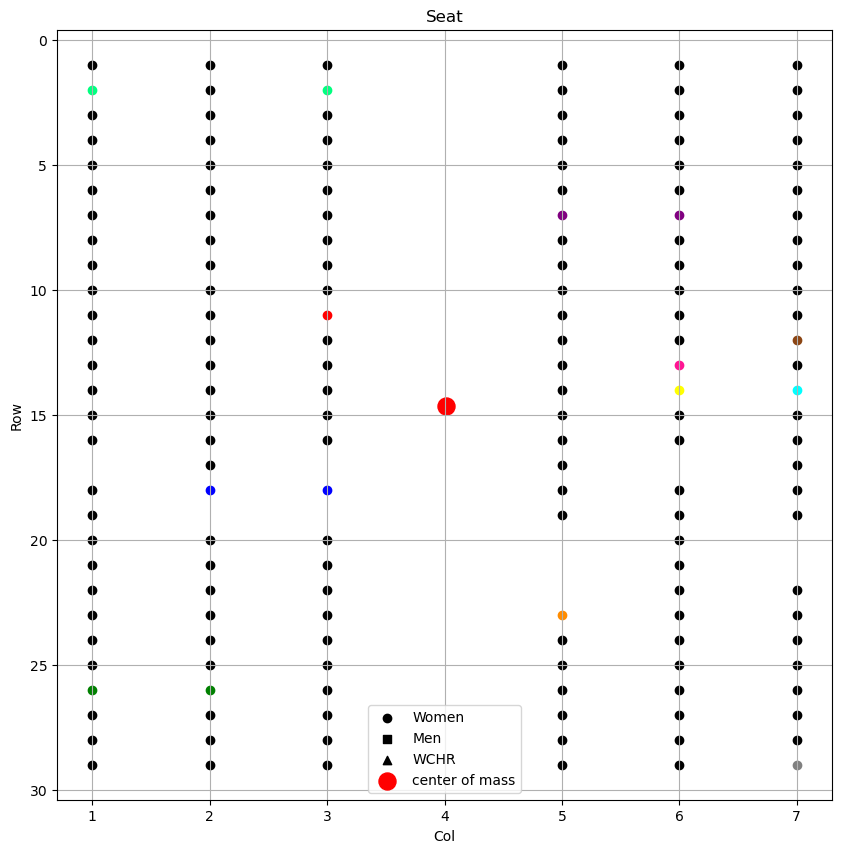

In [50]:
plot_seating(Passengers, seat_coords, x_g, y_g)

Evaluation de la satisfaction client

In [ ]:
#renvoie une liste contenant les indices des passagers dans le groupe de i
def groupe(i, Passengers):
    G=[]
    for k in range(1, n+1):
        if Passengers[i]['group'] == Passengers[k]['group']:
            G+=[k]
    return G

print (groupe(1,Passengers))

In [ ]:
def metrique_groupe (Passengers):
    sat={}

    for i in Passengers:

        group=groupe(i,Passengers)
        group_coord=seat_coordinates(group)
        if len(group) == 2:
            if group_coord [0][1] == group_coord [1][1]:
                sat[i] = 2.5

            if group_coord [0][0] == group_coord [1][0]
                
            

In [ ]:
def metrique_grossière(Passengers):

    sat=0

    for i in Passengers:
        if Passengers[i]['connection_time'] > 0 :
            for j in range (1, ns+1):
                
                if S[(i,j)].x:
                    x, y = seat_coordinates([j])
                    if y <=5:
                        sat += 5
                    elif
                
    return sat